# Create publication ready datasets

Four datasets to publish:
1. AusENDVI-clim 1982-2013 gap-filled (including 'QC' layer)
2. Joined AusENDVI-clim with MODIS 1982-2022 gap-filled (including 'QC' layer)
3. AusENDVI-noclim 1982-2013
4. Synthetic NDVI 1982-2022


In [1]:
import numpy as np
import xarray as xr
from odc.geo.xr import assign_crs

%matplotlib inline

In [2]:
base = '/g/data/os22/chad_tmp/AusENDVI/data/'
crs='EPSG:4326'
version = '0.2.0'

## AusENDVI-clim merged with MODIS-MCD43A4 & gapfilled

In [3]:
clim_nogaps = xr.open_dataset(f'{base}/NDVI_harmonization/LGBM/NDVI_CLIM_LGBM_5km_monthly_1982_2022_noGaps.nc')['NDVI']
clim_nogaps = clim_nogaps.where(clim_nogaps>=0) #ensure values are 0-1
clim_nogaps = assign_crs(clim_nogaps, crs=crs)
clim_nogaps = clim_nogaps.rename('AusENDVI_clim_MCD43A4')
clim_nogaps.attrs['nodata'] = np.nan
clim_nogaps.attrs['crs'] = crs
clim_nogaps.attrs['units'] = 'unitless'
clim_nogaps.attrs['long_name'] = 'AusENDVI_clim merged with MODIS-MCD43A4 NDVI'

#create a QC layer by using the 'gappy' dataset to identify where data was gapfilled.
qc = xr.open_dataset(f'{base}/NDVI_harmonization/LGBM/NDVI_CLIM_LGBM_5km_monthly_1982_2022_wGaps.nc')['NDVI']
qc = assign_crs(qc, crs=crs)
qc = qc.rename('QC').to_dataset()
qc.attrs['nodata'] = np.nan
qc.attrs['crs'] = crs
qc = np.isnan(qc.QC)
sea_mask = np.isnan(clim_nogaps.mean('time'))
qc = xr.where(sea_mask==1, 2, qc)
qc = qc.astype(np.int8)
qc.attrs['crs'] = crs
qc.attrs['nodata'] = 2
qc.attrs['description'] = "The data values in this QC layer have three values: 0, 1, & 2.  A value of 0 describes good observation data preserved from the original Climate Data Record AVHRR NDVI product after QA filtering and the extended filtering/removal of data that is described in this dataset's publication. A value of 1 indicates data that is gap-filled using either synthetic NDVI data or values attained through linear temporal interpolation. A value of 2 indicates pixels where there is no-data in the entire archive, effectively this is a land-sea mask"
qc.attrs['units'] = 'N/A'
qc.attrs['long_name'] = 'Quality Control'

# add QC layert to the clim dataset
clim_nogaps = clim_nogaps.to_dataset()
clim_nogaps['QC'] = qc.transpose('time','latitude', 'longitude')
clim_nogaps['AusENDVI_clim_MCD43A4'].attrs['description'] = "This dataset consists of calibrated and harmonised (to MODIS-MCD43A4 NDVI) Climate Data Record AVHRR NDVI data from Jan. 1982 to Feb. 2000, and MODIS-MCD43A4 NDVI data from Mar. 2000 to Dec. 2022. This version of the dataset used climate data in the calibration and harmonisation process. The dataset has been gap filled with synthetic NDVI data. Timesteps represent monthly median composites."

#add some metadata to dataset.
clim_nogaps.attrs['crs'] = crs
clim_nogaps.attrs['description'] = "See the 'description' attributes on the individual layers of this netcdf file for a full description of each layer."

#export
clim_nogaps.to_netcdf(f'/g/data/os22/chad_tmp/AusENDVI/results/publication/AusENDVI-clim_MCD43A4_gapfilled_1982_2022_{version}.nc')
clim_nogaps

/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


<xarray.Dataset> Size: 1GB
Dimensions:                (longitude: 840, latitude: 680, time: 492)
Coordinates:
  * longitude              (longitude) float32 3kB 112.0 112.1 ... 153.9 154.0
  * latitude               (latitude) float32 3kB -10.02 -10.07 ... -43.97
    spatial_ref            int32 4B 4326
  * time                   (time) datetime64[ns] 4kB 1982-01-15 ... 2022-12-15
Data variables:
    AusENDVI_clim_MCD43A4  (time, latitude, longitude) float32 1GB nan ... nan
    QC                     (time, latitude, longitude) int8 281MB 2 2 2 ... 2 2
Attributes:
    crs:          EPSG:4326
    description:  See the 'description' attributes on the individual layers o...

## AusENDVI Synthetic

In [4]:
syn = xr.open_dataset(f'{base}/synthetic/NDVI/NDVI_CLIM_synthetic_5km_monthly_1982_2022.nc')['NDVI']
syn = syn.where(syn>=0) #ensure values are 0-1
syn = assign_crs(syn, crs=crs)
syn.attrs['nodata'] = np.nan
syn.attrs['crs'] = crs
syn.attrs['description'] = "This dataset consists of synthetic NDVI data that was built by training a model on the joined AusENDVI-clim and MODIS-MCD43A4 NDVI timeseries using climate, woody-cover-fraction, and atmospheric CO2 as predictors. The dataset extends from Jan. 1982 to Dec. 2022 with a monthly time-step."
# del syn.attrs['grid_mapping']
attrs = syn.attrs
syn = syn.rename('AusENDVI_synthetic').to_dataset()
syn.attrs = attrs
syn.attrs['units'] = 'unitless'
syn.attrs['long_name'] =  'AusENDVI Synthetic NDVI'

syn.to_netcdf(f'/g/data/os22/chad_tmp/AusENDVI/results/publication/AusENDVI_synthetic_1982_2022_{version}.nc')

## AusENDVI-clim, gap filled

In [5]:
#merge regions together
trees_clim = xr.open_dataset(f'{base}NDVI_harmonization/LGBM/NDVI_trees_CLIM_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']
nontrees_clim = xr.open_dataset(f'{base}/NDVI_harmonization/LGBM/NDVI_nontrees_CLIM_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']
desert_clim = xr.open_dataset(f'{base}/NDVI_harmonization/LGBM/NDVI_desert_CLIM_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']
merge_clim = xr.where(np.isnan(trees_clim), nontrees_clim, trees_clim)
merge_clim = xr.where(np.isnan(desert_clim), merge_clim, desert_clim)
merge_clim = merge_clim.where(merge_clim>=0) #ensure values are 0-1

# -----gapfill-----
# seperate into climatologies and anomalies
climatology = merge_clim.groupby('time.month').mean()
anomaly = merge_clim.groupby('time.month') - climatology  

# fill anomalies linearly by one-step
anomaly = anomaly.interpolate_na(dim='time', method='linear', limit=1)

# recombine anomalies and climatology
fill = anomaly.groupby('time.month') + climatology
fill = fill.drop_vars('month')
fill = fill.where(fill>=0) #ensure values are still 0-1 after interp

#gapfill with synthetic
merge_clim = fill.fillna(syn['AusENDVI_synthetic'].sel(time=fill.time))

# add attributes
merge_clim.attrs['nodata'] = np.nan
merge_clim.attrs['crs'] = crs
merge_clim.attrs['description'] = "This dataset consists of calibrated and harmonised (to MODIS-MCD43A4 NDVI) Climate Data Record AVHRR NDVI data from Jan. 1982 to Dec. 2013. This version of the dataset used climate data in the calibration and harmonisation process. The dataset has been gap filled with synthetic NDVI data. Timesteps represent monthly median composites."
merge_clim.attrs['units'] = 'unitless'
merge_clim.attrs['long_name'] = 'AusENDVI_clim'

attrs = merge_clim.attrs
merge_clim = merge_clim.rename('AusENDVI_clim').to_dataset()
merge_clim.attrs = attrs

#add QC layer.
merge_clim['QC'] = qc.transpose('time','latitude', 'longitude')

#export
merge_clim.to_netcdf(f'/g/data/os22/chad_tmp/AusENDVI/results/publication/AusENDVI-clim_gapfilled_1982_2013_{version}.nc')
merge_clim

<xarray.Dataset> Size: 1GB
Dimensions:        (longitude: 840, latitude: 680, time: 384)
Coordinates:
  * longitude      (longitude) float32 3kB 112.0 112.1 112.1 ... 153.9 154.0
  * latitude       (latitude) float32 3kB -10.02 -10.07 -10.12 ... -43.92 -43.97
  * time           (time) datetime64[ns] 3kB 1982-01-15 ... 2013-12-15
    spatial_ref    (time) int32 2kB 4326 4326 4326 4326 ... 4326 4326 4326 4326
Data variables:
    AusENDVI_clim  (time, latitude, longitude) float32 877MB nan nan ... nan nan
    QC             (time, latitude, longitude) int8 219MB 2 2 2 2 2 ... 2 2 2 2
Attributes:
    nodata:       nan
    crs:          EPSG:4326
    description:  This dataset consists of calibrated and harmonised (to MODI...
    units:        unitless
    long_name:    AusENDVI_clim

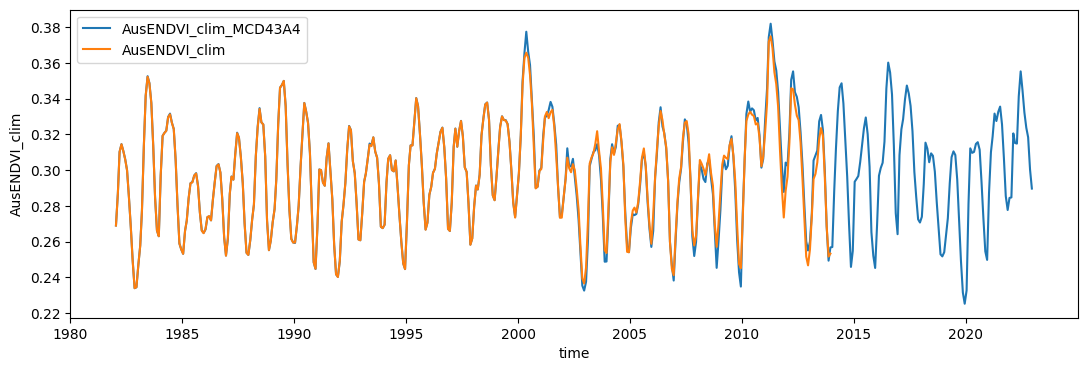

In [6]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1, figsize=(13,4), sharey=True)
clim_nogaps['AusENDVI_clim_MCD43A4'].mean(['latitude','longitude']).plot(ax=ax, label='AusENDVI_clim_MCD43A4')
merge_clim['AusENDVI_clim'].mean(['latitude','longitude']).plot(ax=ax, label='AusENDVI_clim')
ax.legend()

## AusENDVI-noclim

In [7]:
trees_noclim = xr.open_dataset(f'{base}NDVI_harmonization/LGBM/NDVI_trees_NOCLIM_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']
nontrees_noclim = xr.open_dataset(f'{base}/NDVI_harmonization/LGBM/NDVI_nontrees_NOCLIM_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']
desert_noclim = xr.open_dataset(f'{base}/NDVI_harmonization/LGBM/NDVI_desert_NOCLIM_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']
merge_noclim = xr.where(np.isnan(trees_noclim), nontrees_noclim, trees_noclim)
merge_noclim = xr.where(np.isnan(desert_noclim), merge_noclim, desert_noclim)
merge_noclim = merge_noclim.where(merge_noclim>=0) #ensure values are 0-1

merge_noclim.attrs['nodata'] = np.nan
merge_noclim.attrs['crs'] = crs
merge_noclim.attrs['description'] = "This dataset consists of calibrated and harmonised (to MODIS-MCD43A4 NDVI) Climate Data Record AVHRR NDVI data from Jan. 1982 to Dec. 2013. This version of the dataset did not use climate data in the calibration and harmonisation process. The dataset has not been gap filled, and extra data has been filtered/removed beyond the typical QA filtering using methods described in the publication. Timesteps represent monthly median composites."
merge_clim.attrs['units'] = 'unitless'
merge_clim.attrs['long_name'] = 'AusENDVI_noclim'

attrs = merge_noclim.attrs
merge_noclim = merge_noclim.rename('AusENDVI_noclim').to_dataset()
merge_noclim.attrs = attrs

merge_noclim.to_netcdf(f'/g/data/os22/chad_tmp/AusENDVI/results/publication/AusENDVI-noclim_1982_2013_{version}.nc')

## AusENDVI-noclim merged with MODIS-MCD43A4

In [8]:
# noclim_gaps = xr.open_dataset(f'{base}/NDVI_harmonization/LGBM/NDVI_NOCLIM_LGBM_5km_monthly_1982_2022_wGaps.nc')['NDVI']
# noclim_gaps = noclim_gaps.where(noclim_gaps>=0) #ensure values are 0-1
# noclim_gaps = assign_crs(noclim_gaps, crs=crs)
# noclim_gaps = noclim_gaps.rename('AusENDVI_noclim_MCD43A4')
# noclim_gaps.attrs['nodata'] = np.nan
# noclim_gaps.attrs['crs'] = crs
# noclim_gaps.attrs['description'] = "This dataset consists of calibrated and harmonised (to MODIS-MCD43A4 NDVI) Climate Data Record AVHRR NDVI data from Jan. 1982 to Feb. 2000, and MODIS-MCD43A4 NDVI data from Mar. 2000 to Dec. 2022. This version of the dataset did not use climate data in the calibration and harmonisation process. The dataset has not been gap filled. Timesteps represent monthly median composites."
# noclim_gaps.attrs['units'] = 'unitless'
# noclim_gaps.attrs['long_name'] =  'AusENDVI_noclim merged with MODIS-MCD43A4 NDVI'

# attrs = noclim_gaps.attrs
# noclim_gaps = noclim_gaps.to_dataset()
# noclim_gaps.attrs = attrs

# noclim_gaps.to_netcdf('/g/data/os22/chad_tmp/AusENDVI/results/publication/AusENDVI-noclim_MCD43A4_1982_2022.nc')